# Generate Data

This script loads a dataset, trains a classifier and apply a uniform growing sphere generation method to find 'close' ennemy from a given observation

In [1]:
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics.pairwise import manhattan_distances, pairwise_distances



In [2]:
import load_dataset
X, y = load_dataset.main('tennis', 1000, 
                         n_features=10,
                         n_informative=6,
                         n_redundant=0,
                         n_repeated=0,
                         n_clusters_per_class=3)

Index(['Round', 'FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'TPW.1', 'FSP.2', 'FSW.2', 'SSP.2',
       'SSW.2', 'ACE.2', 'DBF.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'TPW.2'],
      dtype='object')
0.44094488189


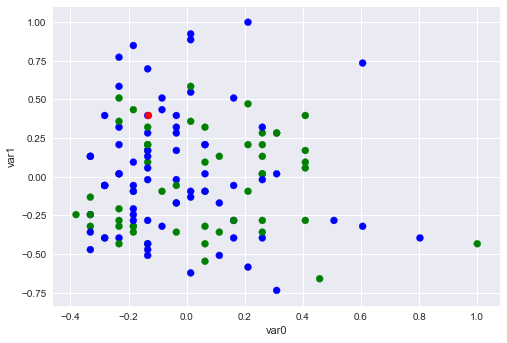

In [93]:
AX1, AX2 = 10, 13

#2D plot
plt.scatter(X[:, AX1], X[:, AX2], color=[['blue', 'green'][int(i)] for i in y])
if 'idx' in globals() and idx <= X.shape[0]:
    plt.scatter(X[idx,AX1], X[idx, AX2], color='red')
plt.xlabel('var0')
plt.ylabel('var1')
plt.show()

# Train a Classifier

In [3]:
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score



X_train, X_test, y_train, y_test = train_test_split(X, y)

#clf = RandomForestClassifier(100)
#clf = SVC(probability=True)
#clf = SGDClassifier('modified_huber')
clf = MLPClassifier(activation='identity')
#clf = BernoulliRBM()
'''logistic = LogisticRegression()
rbm = BernoulliRBM(random_state=0, verbose=True)
clf = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])
'''
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_p = clf.predict_proba(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))
print('auc ', roc_auc_score(y_test, y_pred))

#clf.feature_importances_

accuracy  0.9375
auc  0.937254901961


/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


# Growing Spheres

In [4]:
def pred(obs):
    if len(obs.shape) > 1 and obs.shape[1] > 1:
        return np.array([x[1] for x in clf.predict_proba(obs)])
    else:
        return clf.predict_proba(obs.reshape(1, -1))[0][1]

def distance_first_ennemy(observation):
    D = pairwise_distances(X, observation.reshape(1, -1), metric='euclidean', n_jobs=-1)
    idxes = sorted(enumerate(D), key=lambda x:x[1])
    for i in idxes:
        if clf.predict(X[i[0]].reshape(1, -1)) != clf.predict(observation.reshape(1, -1)):
            return X[i[0]], pairwise_distances(X[i[0]], observation)[0]


### COST MEASURES TO TEST
def l1_norm(observation):
    l1 = sum(map(abs, obs_to_interprete - observation))
    return l1

def weighted_l1(observation):
    exp = sum(map(lambda x: math.exp(x**2), obs_to_interprete - observation))
    return exp

def penalized_l1(observation):
    #nul
    GAMMA_ = 1.0
    l1 = l1_norm(observation)
    nonzeros = sum((obs_to_interprete - observation) != 0)
    return GAMMA_ * nonzeros + l1

cost_measures = [l1_norm, weighted_l1]

In [64]:
'''
GENERATION SPHERE AUTOUR. TROUVER ENNEMIS PUIS PRENDRE LE PLUS PROCHE
'''
from numpy import random as nprand


def generate_inside_ball(center, d, segment=(0,1)):
    #genere une observation de dimension d dans la "boule" de centre center et de rayon segment
    def norm(v):
        return sum(map(lambda x: x**2, v))**(0.5)
    z = nprand.normal(0, 1, d)
    z = z/norm(z) * random.uniform(*segment)**(1/float(d))
    z += center
    return z

def generate_layer_with_pred(center, d, n, segment):
    #generer n observations avec la pred
    out = []
    for i in range(n):
        a = generate_inside_ball(center, d, segment=segment)
        pred = clf.predict(a.reshape(1, -1))
        a = list(a)
        a.append(pred)
        out.append(a)
    return np.array(out)

def seek_ennemies(obs_to_interprete, n_layer=200, step=1/100, enough_ennemies=10):
    PRED_CLASS = clf.predict(obs_to_interprete.reshape(1, -1))
    ennemies = []
    a0 = 0
    i = 0
    a1 = step
    layer_ = []
    '''LAISSER CA MAIS UNIQUEMENT PARCE QUE ON LAISSE ENOUGH ENNEMY A 1'''
    fe, dfe = distance_first_ennemy(obs_to_interprete)
    while len(ennemies) < enough_ennemies and a1 <= dfe:
        layer_ = generate_layer_with_pred(obs_to_interprete, X.shape[1], n=n_layer, segment=(a0, a1))
        layer_enn = [x for x in layer_ if x[-1] == 1-PRED_CLASS]
        ennemies.extend(layer_enn)
        print(i, a1, len(ennemies))
        i += 1
        a0 += step
        a1 += step
    ennemies.append(np.array(list(fe) + [1 - PRED_CLASS]))
    print('final nb of iterations ', i)
    return layer_, ennemies


def growing_sphere_explanation(obs_to_interprete, n_layer=200, step=1/100, enough_ennemies=10, moving_cost=l1_norm):
    layer_, ennemies = seek_ennemies(obs_to_interprete, n_layer, step, enough_ennemies)
    #print('___________', ennemies)
    nearest_ennemy = sorted(ennemies, key=lambda x: moving_cost(x[:-1]))[0][:-1]
    cost = moving_cost(nearest_ennemy)
    print('Obs to interprete', obs_to_interprete)
    print('Nearest ennemy', nearest_ennemy)
    print('Moving cost', cost)
    return nearest_ennemy, cost

# tests

In [8]:
variable_names = ['Round', 'FSP.1', 'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'UFE.1',
       'BPC.1', 'BPW.1', 'NPA.1', 'NPW.1', 'TPW.1', 'FSP.2', 'FSW.2', 'SSP.2',
       'SSW.2', 'ACE.2', 'DBF.2', 'UFE.2', 'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2',
       'TPW.2']

In [5]:
idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])
obs_to_interprete = X[idx]

0 0.01 0
1 0.02 1
final nb of iterations  2
Obs to interprete [ 0.01090343 -0.04118051 -0.52792896  0.04118051 -0.15192744  0.          0.
 -0.23951464 -0.3655914  -0.00315956 -0.23300971 -0.27842599 -0.36337536
 -0.39601901 -0.02579468  0.39601901  0.23030303  0.          0.
 -0.07378939 -0.01735648 -0.29240163 -0.19228095 -0.17153525 -0.1666451 ]
Nearest ennemy [ 0.03344512 -0.01100205 -0.1433451  -0.1072936   0.14173005 -0.08071056
 -0.01137357 -0.4759528  -0.23830506  0.05506007  0.06077948 -0.30209778
 -0.48194    -0.58938306  0.08725715  0.1778762   0.31911782  0.1733206
 -0.06869845 -0.00582349 -0.15743849 -0.37682629 -0.41678064 -0.26677176
 -0.39433002]
Moving cost 25.750379248329367


/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


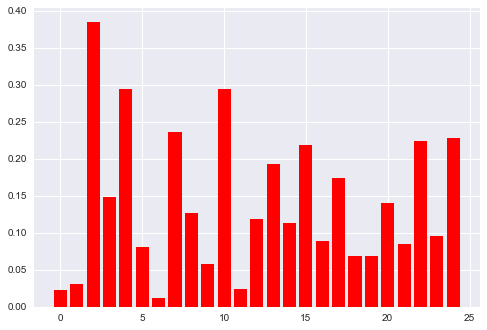

In [95]:
gs_nearest_ennemy, gs_cost = growing_sphere_explanation(obs_to_interprete, moving_cost=weighted_l1, enough_ennemies=1)

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(X.shape[1]), list(map(abs, gs_nearest_ennemy - obs_to_interprete)), color='r')
plt.show()

obs_to_interprete prediction 0.0227715629432
0.557873459346 0.548244357488
28.5247757012 9.89597181913


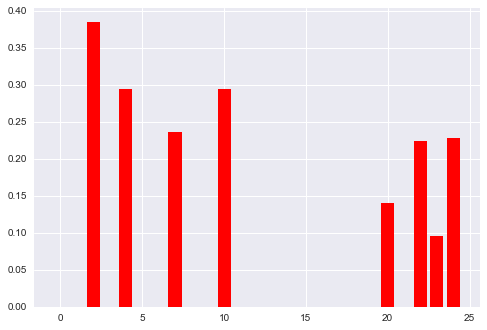

In [118]:
#penalized_l1(gs_nearest_ennemy)

to_cancel = [0, 1, 6, 11, 5, 9, 16, 18, 19, 14, 12, 8, 3, 13, 17, 15, 21]
new = gs_nearest_ennemy.copy()
for var in to_cancel:
    new[var] = obs_to_interprete[var]

print('obs_to_interprete prediction', pred(obs_to_interprete))
print(pred(gs_nearest_ennemy), pred(new))
print(penalized_l1(gs_nearest_ennemy), penalized_l1(new))

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(X.shape[1]), list(map(abs, new - obs_to_interprete)), color='r')
plt.show()

### > il est possible d'avoir bien plus simple en mettant des moves de features à 0

In [61]:

'''rows = []
for i in range(10):
    idx_test = np.random.randint(X_test.shape[0])
    idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])
    obs_to_interprete = X[idx]
    gs_nearest_ennemy, gs_cost = growing_sphere_explanation(obs_to_interprete, step=1/10.0, n_layer=500)
    feats_l1 = [x[0] for x in sorted(enumerate(list(map(abs, gs_nearest_ennemy - obs_to_interprete))), key=lambda x:-x[1])[:3]]
    rows.append([gs_cost, pred(obs_to_interprete), feats_l1,
                 X[idx], gs_nearest_ennemy, pred(X[idx])])'''

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0 0.1 0
1 0.2 0
2 0.30000000000000004 0
3 0.4 0
4 0.5 0
5 0.6 0
6 0.7 0
7 0.7999999999999999 0
8 0.8999999999999999 0
9 0.9999999999999999 0
10 1.0999999999999999 0
11 1.2 0
12 1.3 0
13 1.4000000000000001 0
final nb of iterations  14
___________ [array([-0.18691589,  0.17673301,  0.01775995, -0.17673301, -0.00793651,
        0.        ,  0.        , -0.30651543,  0.18064516, -0.10347551,
       -0.03572816, -0.07504004, -0.09387093, -0.05644682, -0.22433559,
        0.05644682, -0.30848485,  0.        ,  0.        , -0.29342813,
       -0.18691589, -0.12008141, -0.2364395 , -0.19942895, -0.23237159,  1.        ])]
Obs to interprete [-0.18691589  0.22031572 -0.41879118 -0.22031572 -0.51190476  0.          0.
 -0.07201266 -0.50215054 -0.60505529 -0.13436893 -0.13315031 -0.55361378
 -0.50920974 -0.29051589  0.50920974  0.07636364  0.          0.
 -0.26902383  0.15220294  0.22455902 -0.19228095 -0.17153525 -0.1666451 ]
Nearest ennemy [-0.18691589  0.17673301  0.01775995 -0.17673301 -0.0079

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0 0.1 0
1 0.2 1
2 0.30000000000000004 2
3 0.4 5
4 0.5 9
5 0.6 14
final nb of iterations  6
___________ [array([-0.38744361, -0.32364726, -0.16945736,  0.38990579, -0.00220222,
       -0.08094579,  0.16469768, -0.48543462, -0.08740484, -0.20421913,
       -0.2397651 , -0.30365538,  0.10955057,  0.23617775, -0.09636358,
       -0.11533226, -0.13673222,  0.37772236,  0.15403309,  0.42253009,
        0.1884293 ,  0.23565959,  0.00395746, -0.26493784, -0.16905695,  1.        ]), array([ -2.38161659e-03,  -3.97064896e-01,  -4.09177975e-03,
         2.31833754e-01,   5.01321307e-01,   6.03032522e-02,
        -3.11710896e-01,  -5.00284918e-02,   1.28158728e-01,
        -3.31696650e-01,  -1.82920146e-01,  -1.04761260e-01,
         3.01032088e-02,   2.24073706e-02,  -1.54926478e-01,
        -1.83134775e-01,  -3.59140952e-01,  -1.32959712e-01,
         2.42379471e-01,   3.63586400e-01,   1.59468816e-01,
         5.01197842e-01,  -2.65974732e-01,  -2.35266036e-01,
         2.63423829e-04,   1.0000

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your da

0 0.1 0
1 0.2 0
2 0.30000000000000004 0
3 0.4 0
4 0.5 0
5 0.6 0
6 0.7 0
7 0.7999999999999999 0
8 0.8999999999999999 1
9 0.9999999999999999 1
10 1.0999999999999999 1
11 1.2 1
12 1.3 1
13 1.4000000000000001 1
final nb of iterations  14
___________ [array([-0.2130362 , -0.40511376, -0.26710642,  0.18539036,  0.08866096,
        0.15683243, -0.00229711, -0.02678698,  0.03855337,  0.0643363 ,
        0.13786904, -0.0008325 , -0.0851213 , -0.1476371 ,  0.33892503,
        0.20269795, -0.26029974,  0.22975256,  0.1026387 , -0.09669105,
       -0.31439013, -0.12600208, -0.11094149, -0.02484811,  0.04781982,  0.        ]), array([-0.18691589, -0.21551132, -0.09137783,  0.21551132,  0.13605442,
        0.        ,  0.        , -0.13901345, -0.50215054, -0.70537125,
        0.11223301, -0.01692976, -0.28410935, -0.16963755,  0.04038562,
        0.16963755,  0.15333333,  0.        ,  0.        , -0.0981937 ,
       -0.3564753 , -0.37856174, -0.19228095, -0.14364156, -0.10091862,  0.        ])]
Obs

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0 0.1 1
1 0.2 2
2 0.30000000000000004 3
3 0.4 3
4 0.5 4
5 0.6 6
6 0.7 10
final nb of iterations  7
___________ [array([-0.22667763, -0.41357753, -0.27207492,  0.3256087 ,  0.28213985,
       -0.29428497, -0.21461157, -0.1873915 ,  0.31208364,  0.05728329,
       -0.27313723, -0.31726245,  0.14504304,  0.1893142 , -0.15117718,
       -0.23920459, -0.02256188, -0.04471512,  0.029812  ,  0.20085984,
        0.25212311,  0.4364318 , -0.23297807, -0.09193573,  0.10652659,  1.        ]), array([-0.29632016, -0.20650009, -0.30466644,  0.42846461,  0.35648375,
       -0.14442907, -0.17380937, -0.41149957,  0.09177279, -0.26858711,
       -0.85229861, -0.12459253, -0.0615131 ,  0.04396975, -0.06689176,
        0.01508763, -0.18261351, -0.12922724,  0.01663572,  0.2995641 ,
        0.21595747,  0.26953438, -0.19491821, -0.05786874, -0.22375441,  1.        ]), array([-0.3959128 , -0.64650258, -0.14698273,  0.48695832,  0.50520136,
       -0.10945177,  0.03548601, -0.42473136,  0.14486737, -0.2046

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your da

0 0.1 1
1 0.2 1
2 0.30000000000000004 1
3 0.4 3
4 0.5 3
5 0.6 5
6 0.7 5
7 0.7999999999999999 5
8 0.8999999999999999 6
9 0.9999999999999999 7
10 1.0999999999999999 9
11 1.2 9
final nb of iterations  12
___________ [array([ 0.01632991, -0.74424516, -0.1943547 ,  0.59314511,  0.81873773,
       -0.17253332, -0.08111767,  0.21636529,  0.1958532 ,  0.60729057,
        0.29695586,  0.0491446 ,  0.56836593, -0.24348126,  0.10523912,
        0.33038925,  0.82687236,  0.0208814 ,  0.16864547,  0.26113288,
        0.29447241,  0.15755869,  0.15817545,  0.30354386,  0.7148339 ,  0.        ]), array([ 0.1168826 , -0.62672324,  0.07868096,  0.21555304,  0.74892991,
       -0.08975221, -0.05751083,  0.31953412,  0.38371811,  0.91867437,
        0.07938787, -0.18206037,  0.83769253, -0.33313442,  0.28084508,
        0.15148175,  0.58822103,  0.02571455,  0.27246021,  0.31255325,
        0.69619556,  0.47947906,  0.15312844,  0.19187563,  0.78356457,  0.        ]), array([-0.22683372, -0.41092714,  0.

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0 0.1 2
1 0.2 2
2 0.30000000000000004 4
3 0.4 7
4 0.5 8
5 0.6 10
final nb of iterations  6
___________ [array([-0.28973059, -0.41203494,  0.00295364,  0.21412357, -0.05608536,
        0.16037596,  0.08198354, -0.54689776, -0.31950039, -0.21022392,
       -0.34303003, -0.26550792, -0.25584202, -0.54368699, -0.44722021,
        0.46195158, -0.00461957, -0.31223298,  0.04315167, -0.08227377,
       -0.08103959,  0.00869715,  0.06267356, -0.05782426, -0.72311327,  1.        ]), array([-0.17643475, -0.37740142, -0.21671086,  0.56907516,  0.35506134,
       -0.16649477,  0.05111771, -0.33330856, -0.24699402, -0.19032743,
       -0.6349474 , -0.32056905, -0.23141063, -0.47189133, -0.27535769,
        0.50304419, -0.08919988, -0.03556291,  0.16945012,  0.21271518,
       -0.18705794, -0.50083328, -0.03617029, -0.25905181, -0.41315833,  1.        ]), array([-0.1515708 , -0.25136041, -0.21627121,  0.11983004,  0.40550898,
        0.1904436 ,  0.14502902, -0.43874734, -0.47009665, -0.40008499,
  

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


0 0.1 0
1 0.2 0
2 0.30000000000000004 0
3 0.4 1
4 0.5 2
5 0.6 2
6 0.7 4
7 0.7999999999999999 5
8 0.8999999999999999 6
9 0.9999999999999999 8
10 1.0999999999999999 9
11 1.2 10
final nb of iterations  12
___________ [array([-0.04070925,  0.11755877,  0.16272598,  0.07625973,  0.07339823,
       -0.13793438, -0.09132229,  0.53470128,  0.55843506,  1.1807766 ,
        0.11779895, -0.025391  ,  0.30267923,  0.00376402,  0.5377283 ,
       -0.21215397, -0.22312699, -0.12138498,  0.07863714,  0.4231858 ,
        0.57214297,  0.98019198,  0.37748147,  0.78635775,  0.29951605,  1.        ]), array([  7.63219362e-02,   4.18888620e-01,   5.22072836e-01,
         2.71200380e-01,   1.82542627e-01,   8.91099713e-02,
        -2.70559121e-04,   1.71540138e-01,   4.18688631e-01,
         1.13070024e+00,  -4.65655616e-02,  -7.32621764e-02,
         2.50725977e-01,   1.87785290e-01,   2.98527271e-01,
        -2.61627123e-01,  -2.42210045e-01,   7.82253674e-02,
        -2.56924244e-01,   3.90706755e-01,  

/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [62]:
'''gs_output = pd.DataFrame(rows, columns=['cost', 'classification_proba', 'features',
                                        'obs_to_interprete', 'nearest_ennemy', 'obs_pred'])
gs_output'''

,cost,classification_proba,features,obs_to_interprete,nearest_ennemy,obs_pred
0,5.265554,0.000516,"[8, 4, 9]","[-0.18691588785, 0.220315717227, -0.4187911773...","[-0.18691588785, 0.17673301304, 0.017759954167...",0.000516
1,3.692925,0.010064,"[7, 2, 6]","[-0.18691588785, -0.433424845573, -0.382411916...","[-0.223113041792, -0.23476231811, 0.0341203278...",0.010064
2,3.202123,0.031105,"[22, 17, 11]","[-0.18691588785, -0.0411805078929, 0.563448868...","[-0.389319476312, -0.0661702092988, 0.72132804...",0.031105
3,4.101350,0.997213,"[24, 21, 4]","[-0.18691588785, -0.302676733013, -0.127757089...","[-0.213036196773, -0.405113764406, -0.26710641...",0.997213
4,3.353750,0.010064,"[8, 9, 12]","[-0.18691588785, -0.433424845573, -0.382411916...","[-0.226677631196, -0.413577527107, -0.27207492...",0.010064
5,3.544889,0.986443,"[15, 0, 8]","[-0.18691588785, 0.133150308854, 0.05413921512...","[0.227978498702, -0.215550453881, -0.055326790...",0.986443
6,3.430217,0.992138,"[2, 9, 16]","[-0.18691588785, -0.47700754976, 0.19965625895...","[0.0163299100431, -0.744245156869, -0.19435470...",0.992138
7,3.285947,0.012154,"[24, 2, 17]","[0.0109034267913, -0.302676733013, -0.34603265...","[-0.28973058851, -0.412034942072, 0.0029536384...",0.012154
8,3.592620,0.005971,"[2, 1, 9]","[0.208722741433, 0.0459849004804, 0.0541392151...","[0.0763219362113, 0.418888620288, 0.5220728359...",0.005971
9,3.468824,0.023236,"[13, 20, 19]","[0.0109034267913, 0.786890871654, -0.346032655...","[-0.109063964489, 0.890924784557, -0.071806808...",0.023236


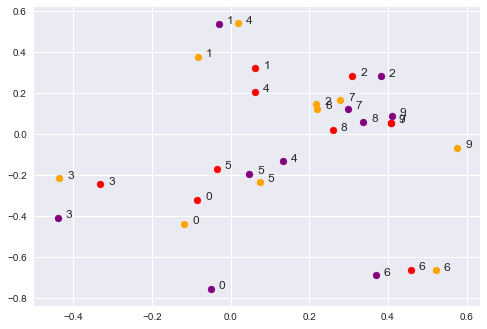

In [147]:
'''plt.scatter([x[AX1] for x in gs_output['obs_to_interprete']], [x[AX2] for x in gs_output['obs_to_interprete']], color='red')
plt.scatter([x[AX1] for x in gs_output['nearest_ennemy_l1']], [x[AX2] for x in gs_output['nearest_ennemy_l1']], color='orange')
plt.scatter([x[AX1] for x in gs_output['nearest_wl1']], [x[AX2] for x in gs_output['nearest_wl1']], color='purple')
for i in range(gs_output.shape[0]):
    plt.text(gs_output['obs_to_interprete'][i][AX1] + 0.02, gs_output['obs_to_interprete'][i][AX2], str(i))
    plt.text(gs_output['nearest_ennemy_l1'][i][AX1] + 0.02, gs_output['nearest_ennemy_l1'][i][AX2], str(i))
    plt.text(gs_output['nearest_wl1'][i][AX1] + 0.02, gs_output['nearest_wl1'][i][AX2], str(i))
plt.show()'''

In [44]:
pred(X[idx +3])

0.00061828754075763694

In [51]:
idx_test = np.random.randint(X_test.shape[0])
idx = int(np.where(np.all(X_test[idx_test] == X, axis=1))[0])
obs_to_interprete = X[idx]

In [30]:
%reset_selective uniform_growing_spheres

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [58]:
import uniform_growing_spheres
import imp
imp.reload(uniform_growing_spheres)
uniform_growing_spheres.main(X, pred, obs_to_interprete)

0 0.01 1
1 0.02 1
2 0.03 8
3 0.04 14
final nb of iterations  4
final number of ennemies generated  15


/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/laugel/Documents/thesis/code/python_env/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


(array([-0.12728959,  0.13661251,  0.30565981,  0.04626643,  0.01616027,
         0.00879589,  0.03801369,  0.00709686,  0.47977369,  0.70375291,
        -0.27310655, -0.03670805,  0.26664457, -0.38684563,  0.41400355,
         0.39751754,  0.12005014, -0.21514043,  0.01065695,  0.23436604,
         0.44347579,  0.48453935,  0.18291593, -0.14384451,  0.49857952]),
 2.9776072229558297)